<a href="https://colab.research.google.com/github/cromi0256/Study01/blob/main/3%EC%9E%A5_%EB%AC%B8%EC%A0%9C%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1번 MNIST 데이터셋 분류기 모델 구축

In [88]:
#데이터셋 불러오기
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [89]:
#데이터 추출
X, y = mnist.data, mnist.target
print(X,y)  #일반탐색
print(X.shape)  #28*28 사이즈의 데이터

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]] ['5' '0' '4' ... '4' '5' '6']
(70000, 784)


8


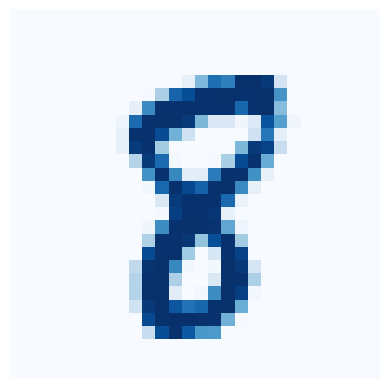

In [92]:
#데이터셋 시각화
import matplotlib.pyplot as plt

def plot_digit(data):
  image = data.reshape(28,28)
  plt.imshow(image, cmap = 'Blues') #임의지정 색상
  plt.axis("off")

i=69420  #사용자지정(0~70000)
sample1=X[i]
plot_digit(sample1)
print(y[i])

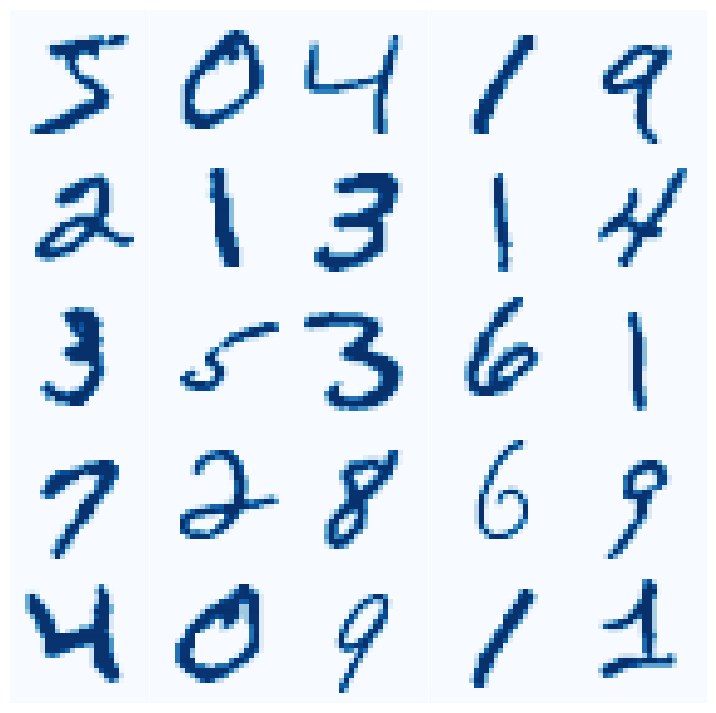

In [94]:
#추가 시각화
plt.figure(figsize=(9,9))
for i in range(25):
  plt.subplot(5,5,i+1)
  plot_digit(X[i])
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

In [95]:
#데이터 분할
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [96]:
#훈련모델 생성
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()  #기본모형
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [97]:
#기본 성능평가
from sklearn.metrics import accuracy_score
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9688

In [98]:
#그리드서치
from sklearn.model_selection import GridSearchCV
param_grid=[
    {'n_neighbors':[4,5,6,7],
    'weights':["uniform","distance"]}
]

gridmodel=GridSearchCV(knn_clf,param_grid,cv=5,verbose=1)
gridmodel.fit(X_train[:12000],y_train[:12000])  #일부만 사용

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [4, 5, 6, 7],
                          'weights': ['uniform', 'distance']}],
             verbose=1)

In [99]:
#그리드서치 결과
print(gridmodel.best_params_)
print(gridmodel.best_score_)

{'n_neighbors': 4, 'weights': 'distance'}
0.9496666666666668


In [100]:
#전체 적용
gridmodel.best_estimator_.fit(X_train,y_train)
score=gridmodel.best_estimator_.score(X_test,y_test)
print('최종결과 모델의 정확도는 {:.2f}%'.format(score*100))

최종결과 모델의 정확도는 97.14%


#2번 데이터증식



In [101]:
#데이터변형
from scipy.ndimage import shift
def shift_image(image, dx, dy):
  image = image.reshape((28, 28))
  shifted_image = shift(image, [dy, dx], cval=0, mode="constant")
  return shifted_image.reshape([-1])

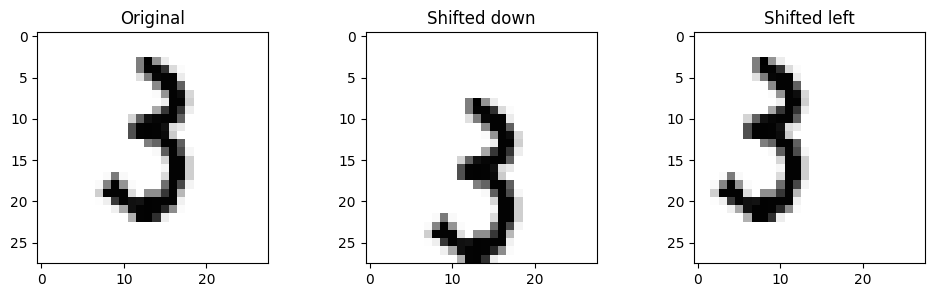

In [103]:
#적용결과 확인
image=X_train[1234]  #임의 샘플 추출
shifted_left=shift_image(image,-5,0)
shifted_down=shift_image(image,0,5)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

In [105]:
import numpy as np
#증식적용
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

#2픽셀씩 이동
for dx, dy in ((-2, 0), (2, 0), (0, 2), (0, -2)):
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(image, dx, dy))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

In [106]:
#데이터 섞기
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [107]:
#모델 적용
knn_clf = KNeighborsClassifier(**gridmodel.best_params_)
knn_clf.fit(X_train_augmented, y_train_augmented)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [111]:
#증식 결과
y_pred = knn_clf.predict(X_test)
accuracy_score(y_test, y_pred)
changed_score=accuracy_score(y_test, y_pred)
print('증식 후 정확도는 {:.2f}%'.format(changed_score*100))

증식 후 정확도는 97.06%


In [112]:
#최종결과
final=changed_score=(1-changed_score)/(1-score)-1
final #증식후 오류율이 조금 늘었음

0.0279720279720288

#3번 타이타닉 데이터 적용